In [ ]:
from google.colab import drive
import pandas as pd
from IPython.core.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
from datetime import datetime, timedelta
import re

## Read in SKU + Sales Data

In [ ]:
# ===============================================================
# 📂 BLOCK 2: MOUNT GOOGLE DRIVE & LOAD DATA FILES
# ===============================================================
drive.mount('/content/drive')

file_path1 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V2.xlsx"
file_path2 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/Sales and Pricing data/V3_Jan. 2022 to August 2025 Sales and Price data.xlsx"

# Load attribute file
df_sku_attributes = pd.read_excel(file_path1, engine="openpyxl")

# Category code → readable name
category_dict = {
    "*":      "COMMON",
    "BACKP":  "Backpack",
    "BBAGS":  "Business Bag",
    "COOL":   "Cooler",
    "DRINK":  "Drinkware",
    "DUF":    "Duffels",
    "FOOD":   "Food",
    "PAD":    "Padfolio",
    "STNRY":  "Stationery",
    "TECH":   "Technology",
    "TOTE":   "Totes",
    "TRAVL":  "Travel",
    "WRITE":  "Writing",
    "LFSTY":  "Lifestyle",
    "PPE":    "Personal Protective Equip.",
    "UMBR":   "Umbrellas",
    "HDWR":   "Headwear",
    "PKG":    "Packaging",
    "BLKTW":  "Blankets and Towels",
    "HOME":   "Home",
    "OFFCE":  "Office",
    "OUTDR":  "Outdoor",
    "SLWPK":  "Slings and Waist Packs",
}


Mounted at /content/drive


## Merge Sales From 2022 - 2025

In [ ]:
# ===============================================================
# 🧮 BLOCK 3: COMBINE SALES DATA (2022–2025)
# ===============================================================
sheet_names = [str(y) for y in range(2022, 2026)]
sheet_dict = pd.read_excel(file_path2, sheet_name=sheet_names, engine="openpyxl")

rename_map = {"Planned Ship Date/Time": "ShipDate", "Sales Qty": "SalesQty"}

frames = []
for name, df in sheet_dict.items():
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    if "ShipDate" in df.columns:
        df["ShipDate"] = pd.to_datetime(df["ShipDate"], errors="coerce")
    if "SalesQty" in df.columns:
        df["SalesQty"] = pd.to_numeric(df["SalesQty"], errors="coerce").fillna(0)
    if "Item" in df.columns:
        df["Item"] = df["Item"].astype(str).str.strip()

    df["year"] = int(name)
    frames.append(df)

combined_df = pd.concat(frames, ignore_index=True)

if "ShipDate" in combined_df.columns:
    combined_df = combined_df.dropna(subset=["ShipDate"]).reset_index(drop=True)


## Remove's SKU's w/out Subcategory Desc + Discontinued

In [ ]:
# ===============================================================
# 🧹 BLOCK 4: CLEAN ATTRIBUTE HEADERS & DROP EMPTY FIELDS
# ===============================================================
df_sku_attributes.columns = df_sku_attributes.columns.str.strip()
df_sku_attributes["Item"] = df_sku_attributes["Item"].astype(str).str.strip()

subcat_col = "Subcategory Desc"
status_col = "Status Code"

# If CommGroup2 exists, we keep it, but do NOT filter on it anymore
commgroup2_col = "CommGroup2 Desc" if "CommGroup2 Desc" in df_sku_attributes.columns else None

before = len(df_sku_attributes)

# ✅ Only enforce: Subcategory Desc must exist + not blank
df_sku_attributes = df_sku_attributes[
    df_sku_attributes[subcat_col].astype(str).str.strip() != ""
]
df_sku_attributes = df_sku_attributes.dropna(subset=[subcat_col])

after = len(df_sku_attributes)

print(f"Removed {before - after} rows with empty '{subcat_col}'.")
print(f"Remaining rows (active only): {len(df_sku_attributes)}")


Removed 8 rows with empty 'Subcategory Desc'.
Remaining rows (active only): 2401


## Category Expanded Added + Intro Code Changed

In [ ]:
# ===============================================================
# 🧭 BLOCK 5: CLEAN & ENRICH ATTRIBUTE DATA (No CommGroup2; All Categories)
# ===============================================================
def find_col(cols, target):
    t = target.lower().replace(' ', '').replace('_', '')
    for c in cols:
        if c.lower().replace(' ', '').replace('_', '') == t:
            return c
    raise KeyError(f"Column '{target}' not found.")

def find_col_optional(cols, target):
    try:
        return find_col(cols, target)
    except KeyError:
        return None

# --- Locate required/optional columns
item_col       = find_col(df_sku_attributes.columns, "Item")
category_col   = find_col(df_sku_attributes.columns, "Category")
subcat_col     = find_col(df_sku_attributes.columns, "Subcategory Desc")
intro_code_col = find_col(df_sku_attributes.columns, "Intro Code")
commgroup2_col = find_col_optional(df_sku_attributes.columns, "CommGroup2 Desc")  # optional now

# --- Standardize core text fields (only those that exist)
df_tmp = df_sku_attributes.copy()
for c in [item_col, category_col, subcat_col, intro_code_col, commgroup2_col]:
    if c is not None and c in df_tmp.columns:
        df_tmp[c] = df_tmp[c].astype(str).str.strip()

# --- Preserve raw intro code for OOC detection
df_tmp["Intro Code (Raw)"] = df_tmp[intro_code_col].astype(str).str.strip().str.upper()

# --- Expand category codes → readable names
cat_upper = df_tmp[category_col].str.upper()
df_tmp["Category (Expanded)"] = cat_upper.map(category_dict).fillna(df_tmp[category_col])

# --- Parse Intro Codes (e.g., "JAN 22" → Timestamp)
MONTHS = {m: i for i, m in enumerate(
    ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"], start=1)}

def parse_intro_code(code: str):
    if not code or str(code).upper() in {"NA", "NAN"}:
        return pd.NaT
    m = re.match(r'^\s*([A-Za-z]{3})\s*(\d{2})\s*$', str(code))
    if not m:
        return pd.NaT
    mon_abbr, yy = m.group(1).upper(), m.group(2)
    mon = MONTHS.get(mon_abbr)
    if not mon:
        return pd.NaT
    year = 2000 + int(yy)
    try:
        return pd.Timestamp(year=year, month=mon, day=1)
    except Exception:
        return pd.NaT

df_tmp["Intro_ParsedDate"] = df_tmp[intro_code_col].map(parse_intro_code)
df_tmp[intro_code_col] = df_tmp["Intro_ParsedDate"].dt.strftime("%b %Y")

# --- Canonical item key
df_tmp["Item_norm"] = df_tmp[item_col].astype(str).str.strip()

# ✅ NOTE:
# We no longer filter to Backpack and we no longer enforce/require CommGroup2.
# Any later logic should use Category (Expanded) and Subcategory Desc only.


In [ ]:
# ===============================================================
# 🔗 BLOCK 6: MERGE SALES DATA WITH ATTRIBUTE DATA (No CommGroup2 dependency)
# ===============================================================
combined_df = combined_df.copy()
combined_df["Item_key"] = combined_df["Item"].astype(str).str.strip()

# --- Build the attribute slice columns dynamically ---
attr_cols = [item_col, "Item_norm", category_col, "Category (Expanded)",
             subcat_col, "Intro_ParsedDate", intro_code_col, "Intro Code (Raw)"]

# include CommGroup2 only if it exists
if ('CommGroup2 Desc' in df_tmp.columns) or (commgroup2_col is not None and commgroup2_col in df_tmp.columns):
    attr_cols.insert(attr_cols.index(subcat_col) + 1, commgroup2_col)  # place next to subcat

# Deduplicate by Item_norm, keep latest intro
attrs_slice = (
    df_tmp[attr_cols]
      .sort_values(["Item_norm", "Intro_ParsedDate"], na_position="last")
      .drop_duplicates(subset=["Item_norm"], keep="last")
)

# --- Build rename map safely (only for cols that are present) ---
rename_map = {
    item_col: "Item_attr",
    category_col: "Category",
    subcat_col: "Subcategory Desc",
    intro_code_col: "Intro Code",
}
if ("CommGroup2 Desc" in attrs_slice.columns) or (commgroup2_col in attrs_slice.columns):
    rename_map[commgroup2_col] = "CommGroup2 Desc"

attrs_slice = attrs_slice.rename(columns=rename_map)

# --- Merge onto sales ---
merged_sales = combined_df.merge(
    attrs_slice.rename(columns={"Item_norm": "Item_key"}),
    on="Item_key",
    how="left"
)

merged_sales["Item"] = merged_sales["Item_key"]
merged_sales = merged_sales.drop(columns=["Item_key"])

# ✅ NEW: ensure CommGroup2 Desc exists even if attributes didn’t have it
if "CommGroup2 Desc" not in merged_sales.columns:
    merged_sales["CommGroup2 Desc"] = "N/A"

# --- Diagnostics ---
print(f"Merged rows: {len(merged_sales):,}")
sample_cols = [c for c in ["Category", "Category (Expanded)", "Subcategory Desc",
                           "CommGroup2 Desc", "Intro Code", "Intro_ParsedDate"]
               if c in merged_sales.columns]
print("Sample columns now present:", sample_cols)

unmatched = merged_sales["Category"].isna().sum()
print(f"Unmatched sales rows (no attribute hit): {unmatched:,}")

# Drop unmatched for downstream simplicity
before_rows = len(merged_sales)
unmatched_mask = merged_sales["Category"].isna()
dropped_rows = int(unmatched_mask.sum())
merged_sales = merged_sales[~unmatched_mask].reset_index(drop=True)

print(f"Safety Check: Dropped unmatched sales rows: {dropped_rows:,}")
print(f"Remaining merged sales rows: {len(merged_sales):,}")


Merged rows: 624,603
Sample columns now present: ['Category', 'Category (Expanded)', 'Subcategory Desc', 'CommGroup2 Desc', 'Intro Code', 'Intro_ParsedDate']
Unmatched sales rows (no attribute hit): 205,216
Safety Check: Dropped unmatched sales rows: 205,216
Remaining merged sales rows: 419,387


In [ ]:
# ===============================================================
# 🚫 BLOCK 6A: DROP OOC / PPE / PAD / <NA> / PRE-2022 INTRO CODES / NO-COLOR / NO-SUBCATEGORY
# ===============================================================
removed_counts = {}

# 1️⃣ Intro Code = OOC*
if "Intro Code (Raw)" in merged_sales.columns:
    mask_ooc = merged_sales["Intro Code (Raw)"].astype(str).str.upper().str.startswith("OOC")
else:
    mask_ooc = pd.Series(False, index=merged_sales.index)
removed_counts["Intro Code = OOC*"] = int(mask_ooc.sum())

# 2️⃣ Category = PPE or PAD
mask_badcat = merged_sales["Category"].astype(str).str.upper().isin(["PPE", "PAD"])
removed_counts["Category in {PPE, PAD}"] = int(mask_badcat.sum())

# 3️⃣ Category = <NA>
mask_na_cat = merged_sales["Category"].isna()
removed_counts["Category = <NA>"] = int(mask_na_cat.sum())

# 4️⃣ Intro Code (Parsed Date) before Jan 2022
if "Intro_ParsedDate" in merged_sales.columns:
    cutoff_date = pd.Timestamp(2022, 1, 1)
    mask_pre2022 = merged_sales["Intro_ParsedDate"].notna() & (merged_sales["Intro_ParsedDate"] < cutoff_date)
else:
    mask_pre2022 = pd.Series(False, index=merged_sales.index)
removed_counts["Intro Code before Jan 2022"] = int(mask_pre2022.sum())

# 5️⃣ Color missing / blank → drop (check nulls BEFORE casting to str)
if "Color" in merged_sales.columns:
    col_color = merged_sales["Color"]
    mask_nocolor = (
        col_color.isna() |
        col_color.astype(str).str.strip().eq("") |
        col_color.astype(str).str.lower().str.strip().isin({"nan", "none"})
    )
else:
    mask_nocolor = pd.Series(False, index=merged_sales.index)
removed_counts["Color missing/blank"] = int(mask_nocolor.sum())

# 6️⃣ Subcategory missing / blank → drop (needed for Category→Subcategory analysis)
if "Subcategory Desc" in merged_sales.columns:
    col_sub = merged_sales["Subcategory Desc"]
    mask_no_subcat = (
        col_sub.isna() |
        col_sub.astype(str).str.strip().eq("") |
        col_sub.astype(str).str.lower().str.strip().isin({"nan", "none"})
    )
else:
    mask_no_subcat = pd.Series(False, index=merged_sales.index)
removed_counts["Subcategory missing/blank"] = int(mask_no_subcat.sum())

# 🧹 Apply all drops
drop_mask = mask_ooc | mask_badcat | mask_na_cat | mask_pre2022 | mask_nocolor | mask_no_subcat
before_rows = len(merged_sales)
merged_sales = merged_sales[~drop_mask].reset_index(drop=True)

print("\nSummary of removed sales rows:")
for k, v in removed_counts.items():
    print(f"  {k}: {v}")
print(f"[Dropping] Remaining sales rows: {len(merged_sales):,}")

# Rows by year (if present)
if "year" in merged_sales.columns:
    print("[Dropping] Rows by year:")
    print(merged_sales["year"].value_counts().sort_index())



Summary of removed sales rows:
  Intro Code = OOC*: 1756
  Category in {PPE, PAD}: 0
  Category = <NA>: 0
  Intro Code before Jan 2022: 265130
  Color missing/blank: 0
  Subcategory missing/blank: 0
[Dropping] Remaining sales rows: 152,501
[Dropping] Rows by year:
year
2022    12545
2023    28911
2024    57569
2025    53476
Name: count, dtype: int64


## 3 Level Filtered Analysis on Backpacks

(Skipping Commuter | Laptop: 28 SKUs)
(Skipping Campus | Laptop: 14 SKUs)


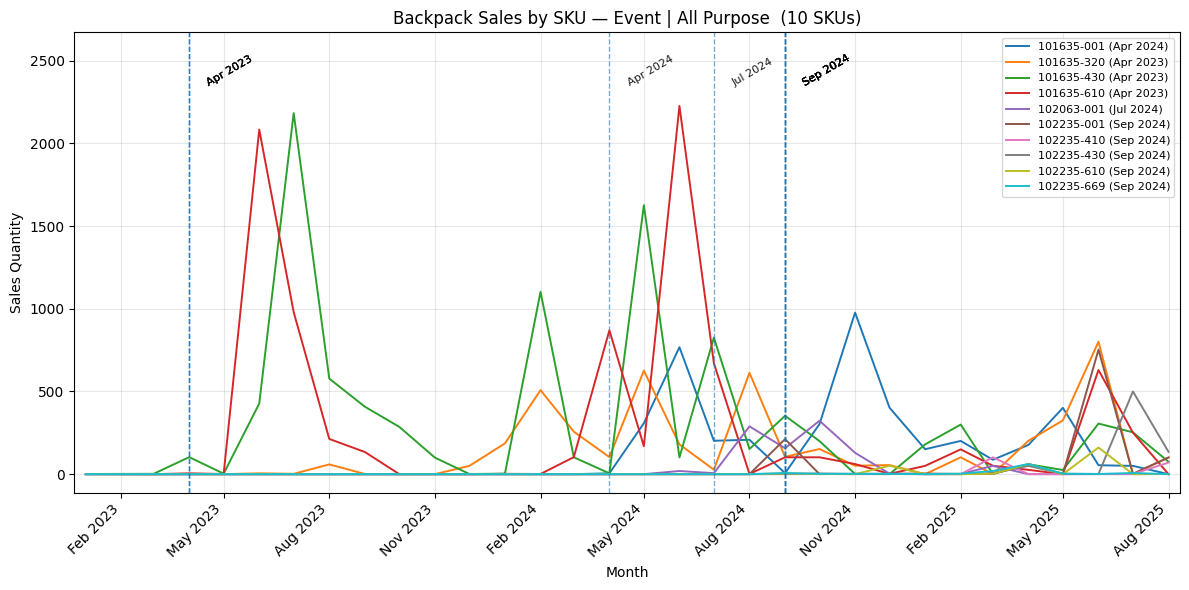

(Skipping Event | Cinchpack: 17 SKUs)


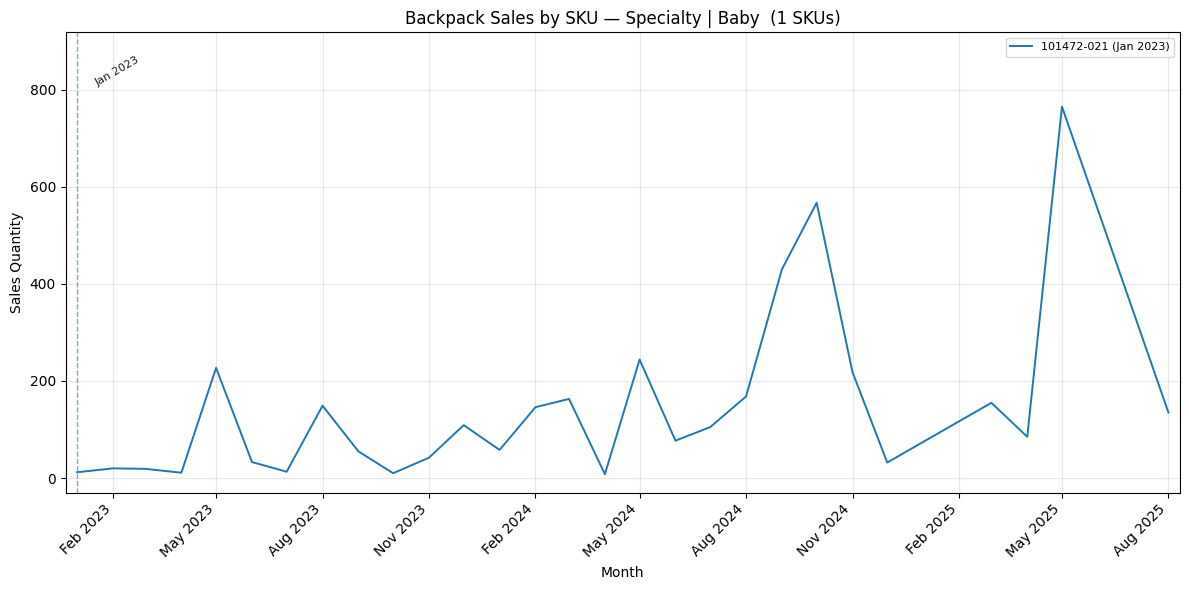

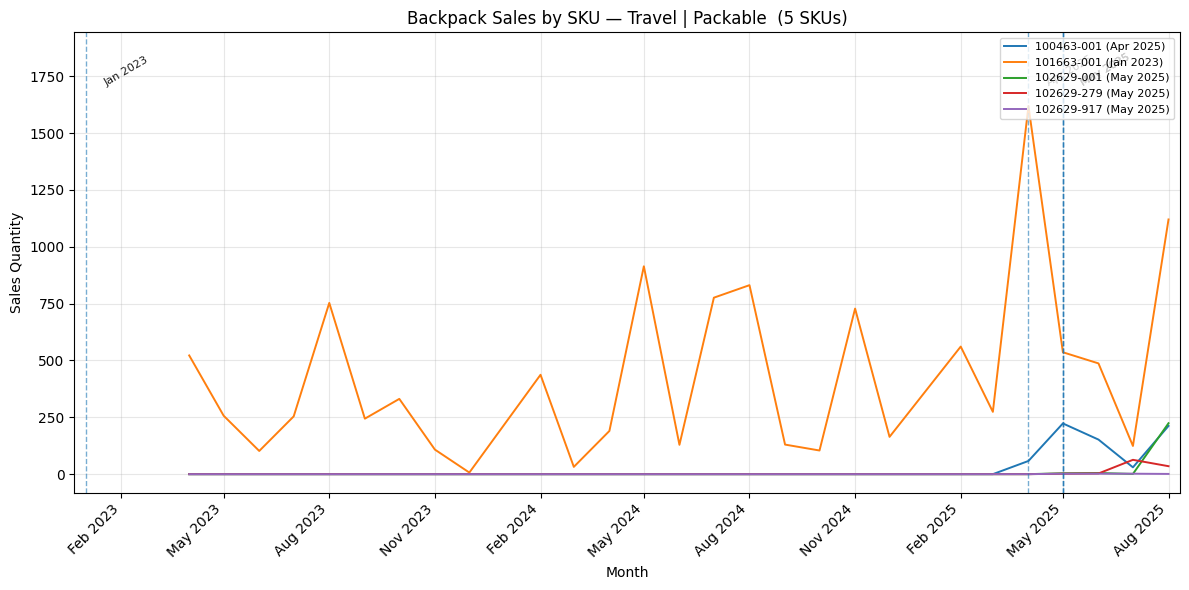

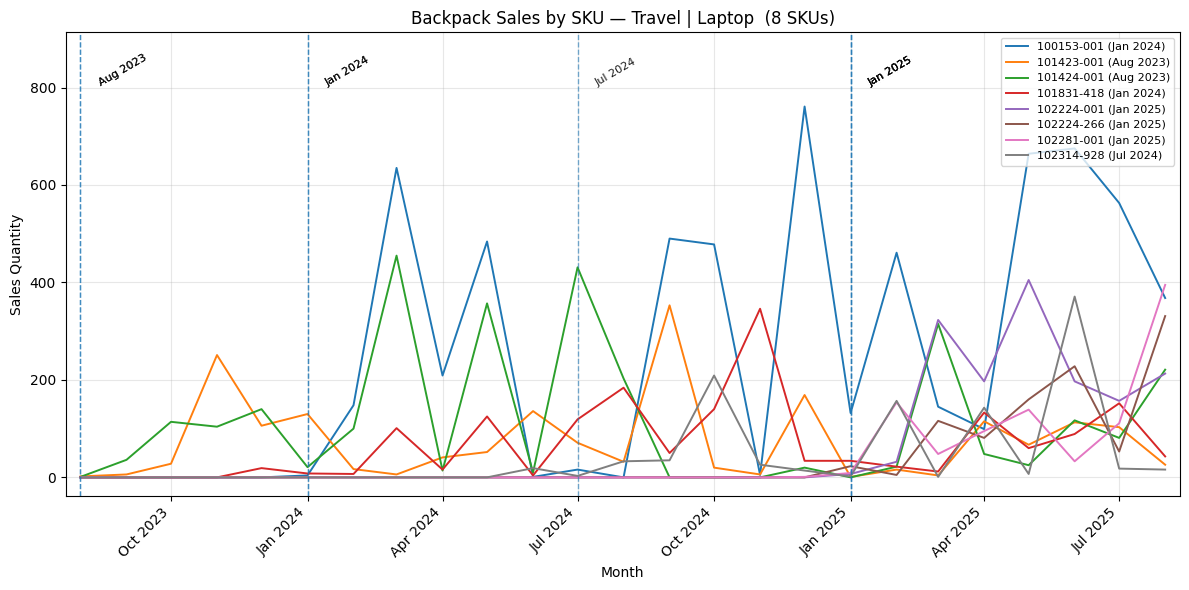

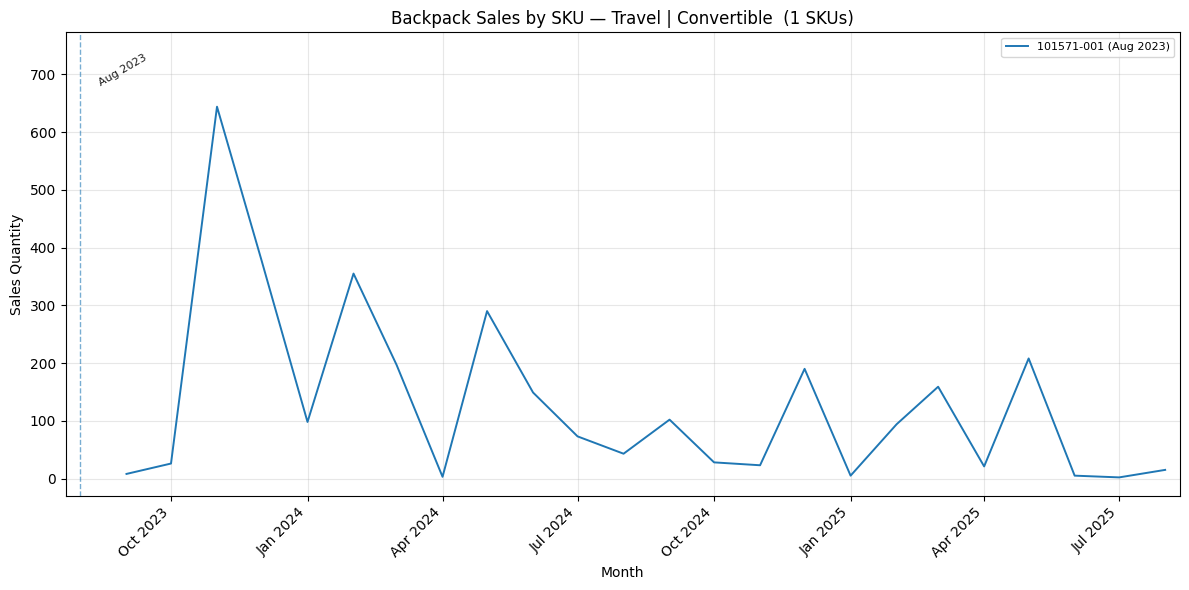

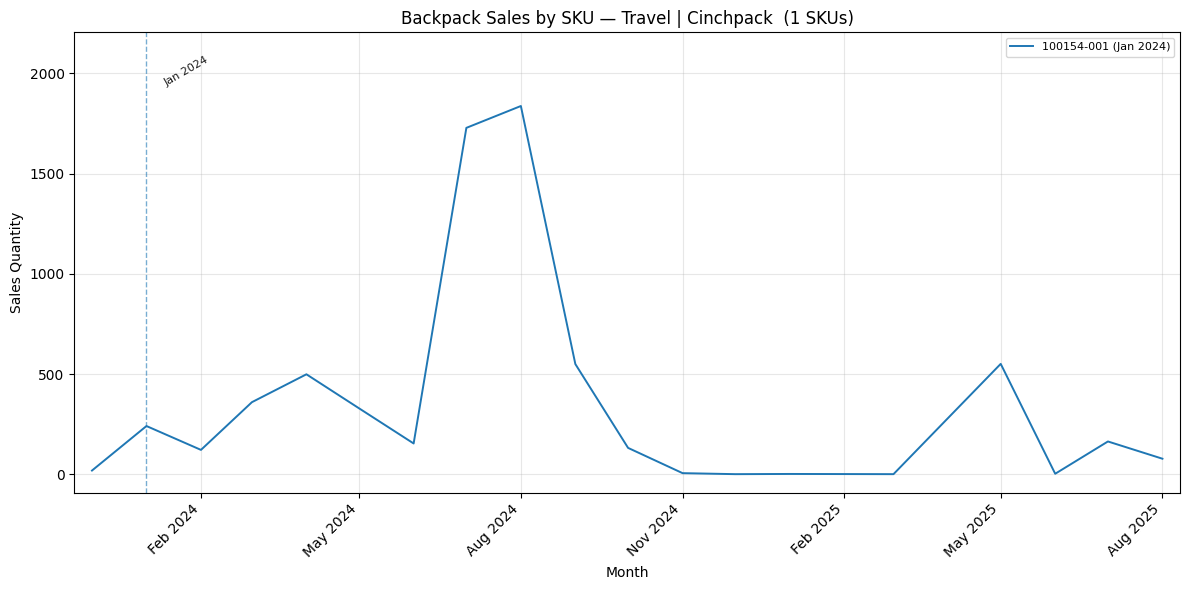

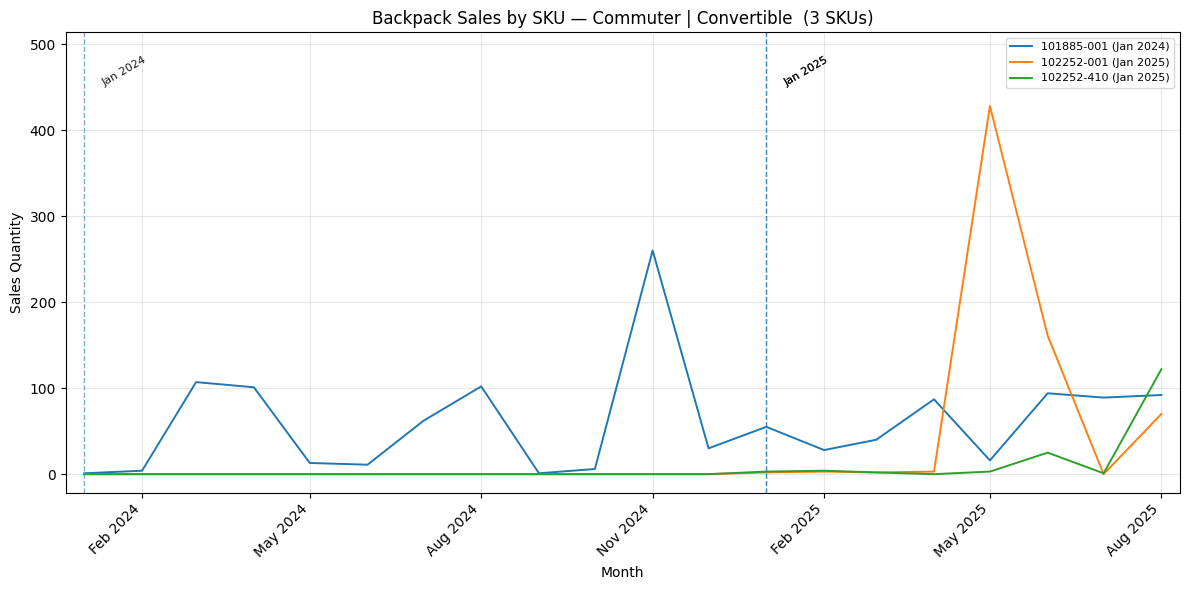

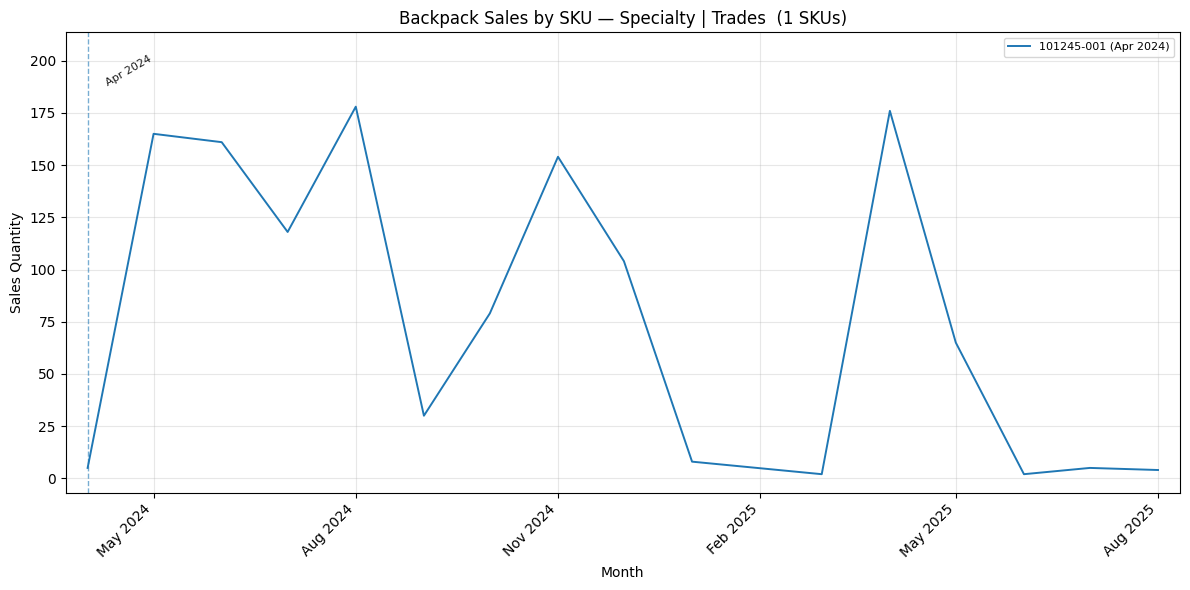

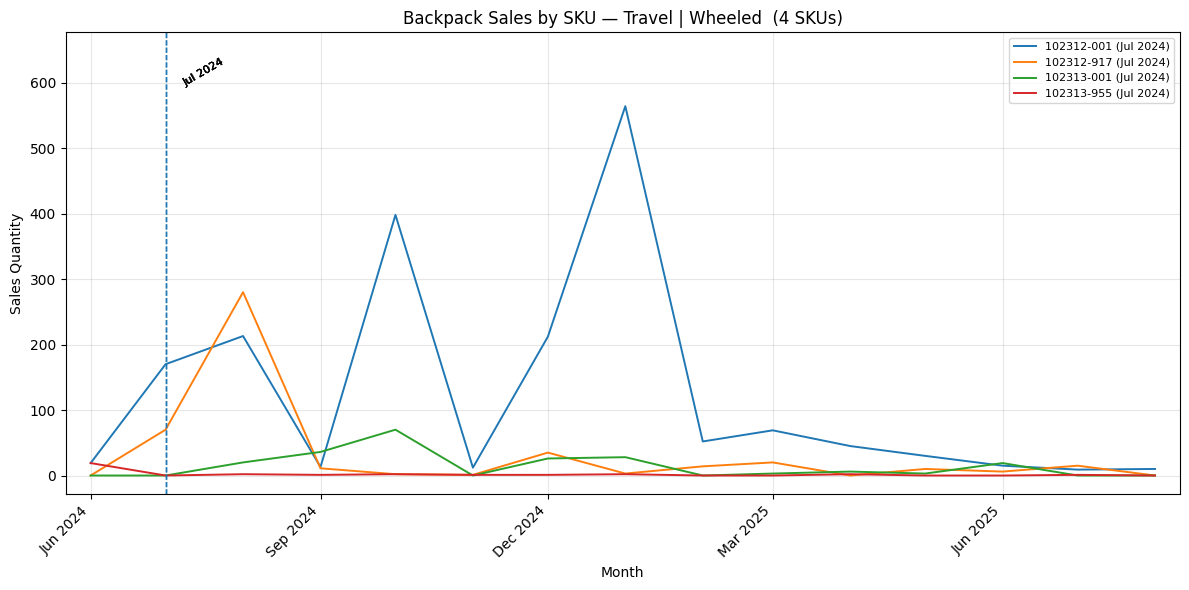

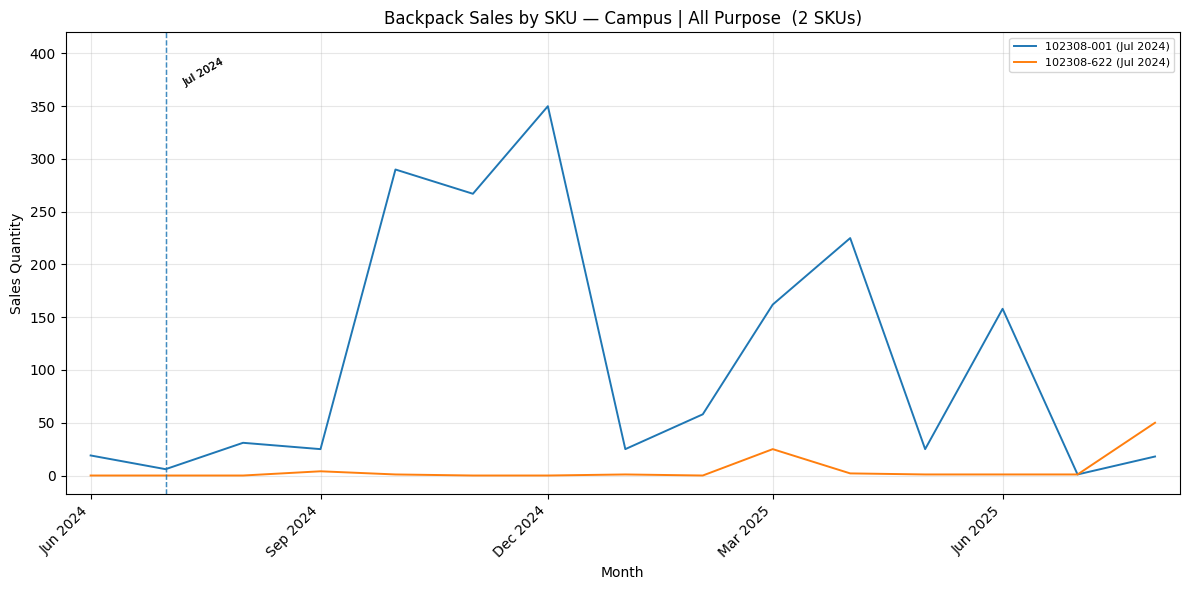

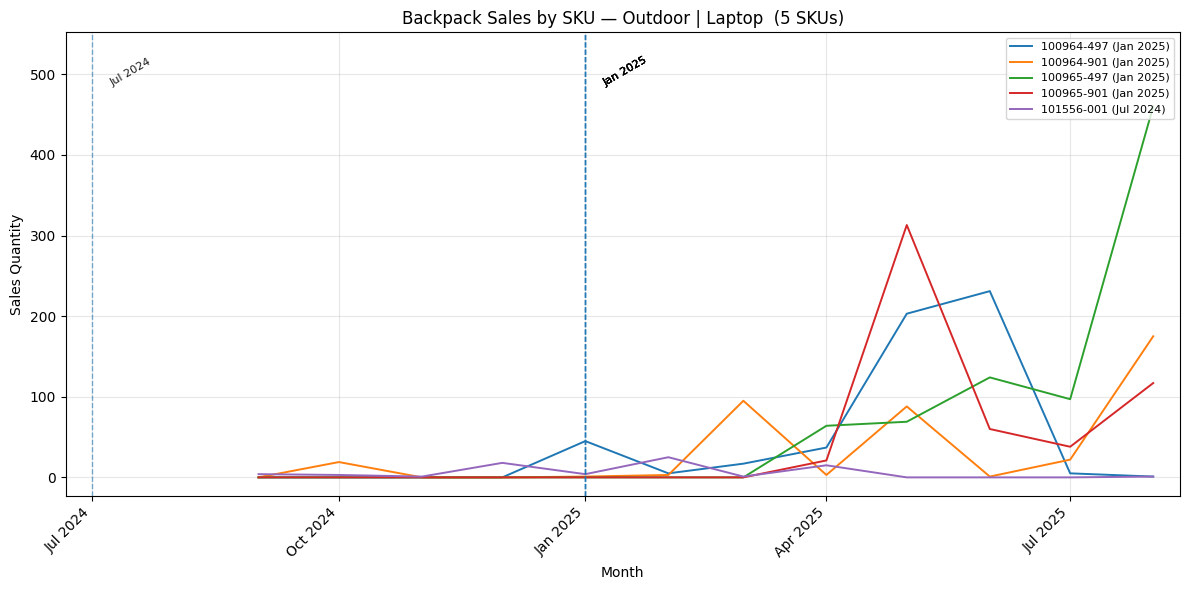

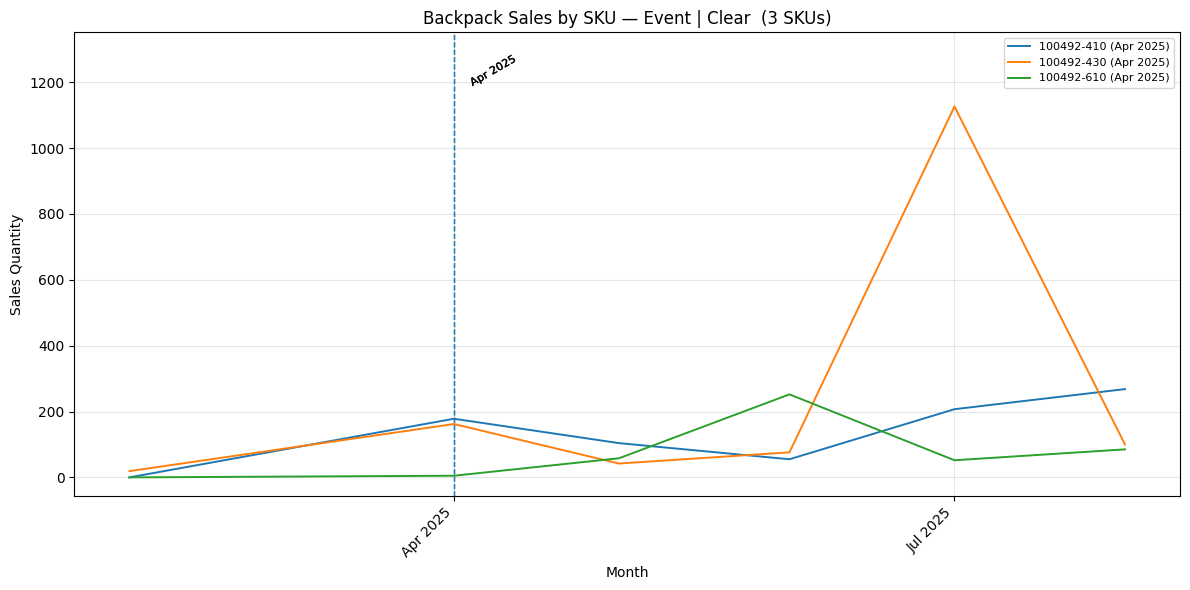

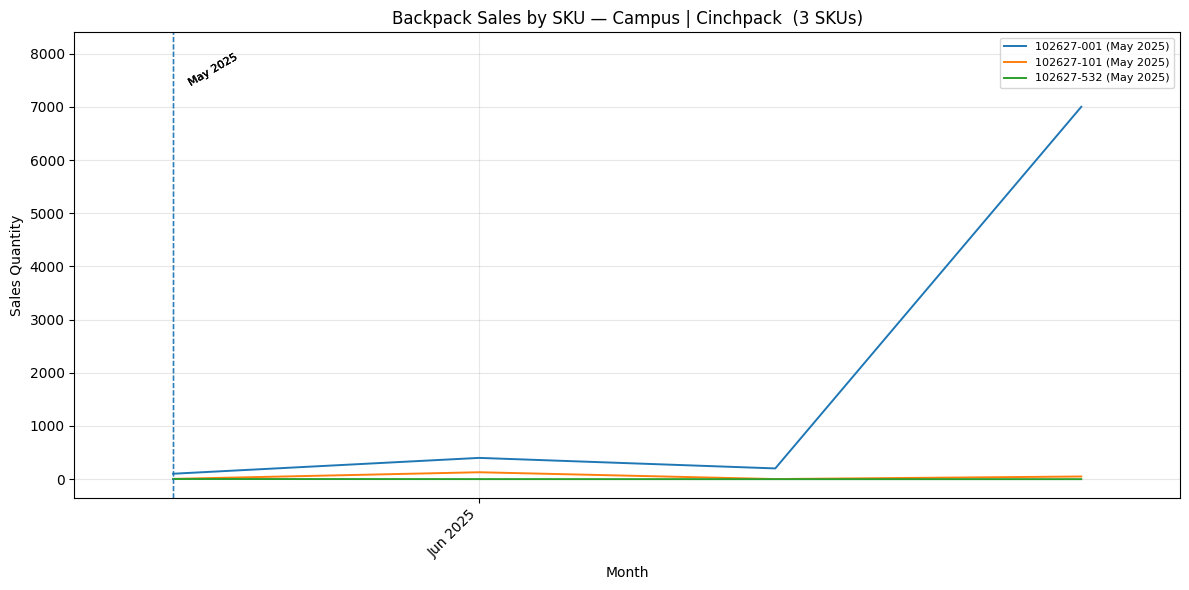

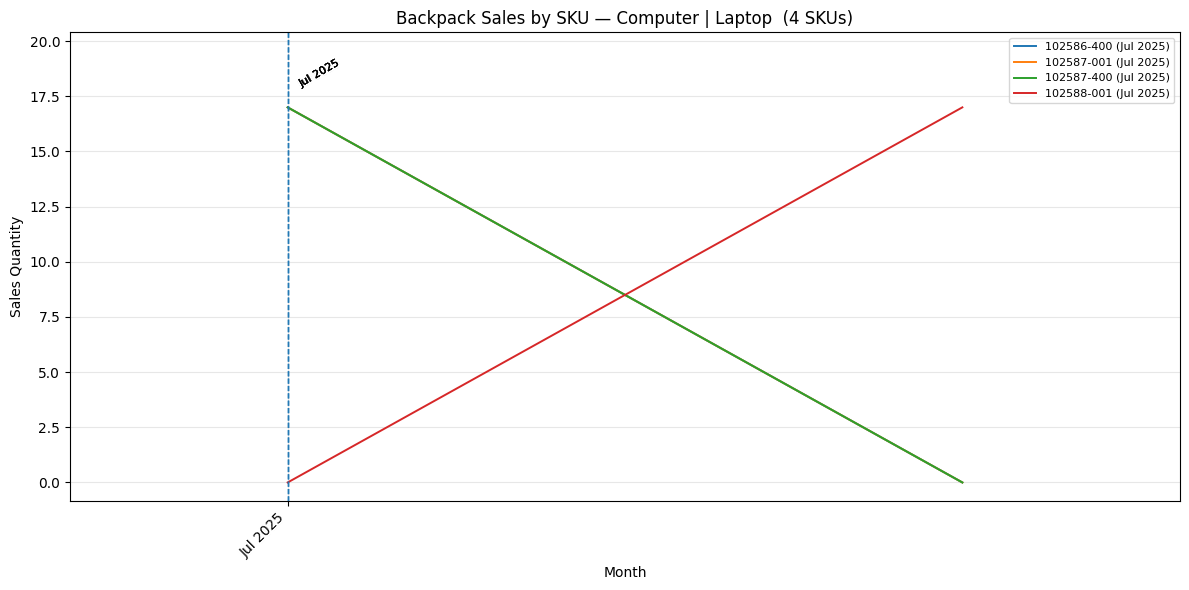

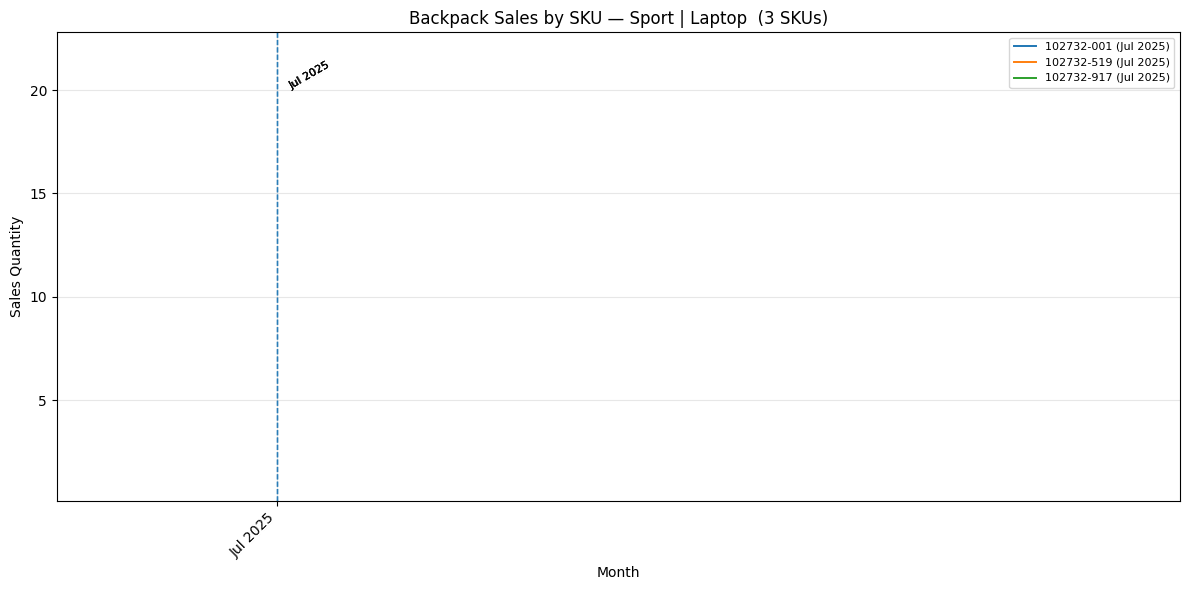

In [ ]:
# ===============================================================
# 📈 Monthly plots by (Subcategory, CommGroup2)
#    — Intros ≥ Jan 2022, Quarterly x-axis, ≤10 SKUs only
# ===============================================================
# Ensure ShipDate is datetime
merged_sales["ShipDate"] = pd.to_datetime(merged_sales["ShipDate"], errors="coerce")

# Keep only Backpacks with valid intros after Jan 2022
cutoff = pd.Timestamp(2022, 1, 1)
backp_sales = merged_sales[
    (merged_sales["Category (Expanded)"] == "Backpack")
    & (merged_sales["Intro_ParsedDate"].notna())
    & (merged_sales["Intro_ParsedDate"] >= cutoff)
].copy()

# Map SKU → intro date
sku_intro_map = (
    backp_sales[["Item", "Intro_ParsedDate"]]
    .drop_duplicates(subset=["Item"])
    .set_index("Item")["Intro_ParsedDate"]
    .to_dict()
)

# Unique (Subcategory, CommGroup2) pairs
pairs = (
    backp_sales[["Subcategory Desc", "CommGroup2 Desc"]]
    .dropna()
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

for sub, grp2 in pairs:
    # Slice data for this subcategory/group
    sub_df = backp_sales[
        (backp_sales["Subcategory Desc"] == sub) &
        (backp_sales["CommGroup2 Desc"] == grp2)
    ].copy()

    # Monthly aggregation
    sub_df["Month"] = sub_df["ShipDate"].dt.to_period("M").dt.to_timestamp()
    grouped = sub_df.groupby(["Month", "Item"], as_index=False)["SalesQty"].sum()
    pivot_df = grouped.pivot(index="Month", columns="Item", values="SalesQty").fillna(0)

    # Skip empty or overcrowded graphs (>10 SKUs)
    n_skus = len(pivot_df.columns)
    if n_skus == 0:
        print(f"(No sales to plot for: {sub} | {grp2})")
        continue
    if n_skus > 10:
        print(f"(Skipping {sub} | {grp2}: {n_skus} SKUs)")
        continue

    # Collect intro dates and define x-axis span
    panel_skus = list(pivot_df.columns)
    panel_intros = {sku: sku_intro_map.get(sku) for sku in panel_skus}
    valid_intro_list = [dt for dt in panel_intros.values() if pd.notna(dt)]

    xmin_sales, xmax_sales = pivot_df.index.min(), pivot_df.index.max()
    if valid_intro_list:
        xmin_all = min(xmin_sales, min(valid_intro_list))
        xmax_all = max(xmax_sales, max(valid_intro_list))
    else:
        xmin_all, xmax_all = xmin_sales, xmax_sales

    # --- Plot ---
    plt.figure(figsize=(12, 6))

    # Plot each SKU line (with intro in legend)
    for sku in panel_skus:
        intro_dt = panel_intros.get(sku)
        label = f"{sku} ({intro_dt:%b %Y})" if pd.notna(intro_dt) else f"{sku} (intro: n/a)"
        plt.plot(pivot_df.index, pivot_df[sku], linewidth=1.4, label=label)

    # Axes setup
    pad_days = pd.Timedelta(days=10)
    plt.xlim(xmin_all - pad_days, xmax_all + pad_days)

    y_top = float(pivot_df.max().max()) if pivot_df.values.size else 0.0
    if y_top <= 0:
        y_top = 1.0
    x_span = (xmax_all - xmin_all) if xmax_all > xmin_all else pd.Timedelta(days=1)
    x_offset = x_span * 0.015

    # Intro markers
    for sku, intro_dt in panel_intros.items():
        if pd.notna(intro_dt):
            plt.axvline(intro_dt, linestyle="--", linewidth=1.0, alpha=0.6)
            plt.text(
                intro_dt + x_offset, y_top * 1.05,
                intro_dt.strftime("%b %Y"),
                rotation=30, ha="left", va="bottom",
                fontsize=8, alpha=0.9, clip_on=False
            )

    # === Quarterly x-axis ticks ===
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # e.g. "Jan 2023"
    plt.xticks(rotation=45, ha="right")

    # Cosmetics
    plt.ylim(top=y_top * 1.2)
    plt.title(f"Backpack Sales by SKU — {sub} | {grp2}  ({n_skus} SKUs)")
    plt.xlabel("Month")
    plt.ylabel("Sales Quantity")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right", fontsize=8, ncol=1)
    plt.tight_layout()
    plt.show()


In [ ]:
# ===============================================================
# Cannibalization — Category → Subcategory (with intro fallback)
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.dates as mdates

# ---- knobs ----
CAT_COL   = 'Category (Expanded)'   # expanded category name
SUB_COL   = 'Subcategory Desc'
DATE_MIN  = pd.Timestamp(2022, 1, 1)
WIN_PRE   = 3     # months before intro
WIN_POST  = 3     # months after intro
MAX_LINES = 14    # max SKUs on a plot

# ---- required cols ----
_required = {'Item','ShipDate','SalesQty',CAT_COL,SUB_COL,'Intro_ParsedDate'}
missing = [c for c in _required if c not in merged_sales.columns]
if missing:
    raise ValueError(f"merged_sales is missing required columns: {missing}")

# ---- prep monthly panel & intro fallback ----
sales = merged_sales.copy()
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], errors='coerce')
sales = sales.dropna(subset=['ShipDate'])
sales['Month'] = sales['ShipDate'].dt.to_period('M').dt.to_timestamp()

# Use Intro_ParsedDate if present, else fallback to first observed sales month
first_sale = (sales.groupby('Item', as_index=False)
                   .agg(FirstSale=('Month','min')))
sales = sales.merge(first_sale, on='Item', how='left')
sales['Intro_Use'] = np.where(sales['Intro_ParsedDate'].notna(),
                              sales['Intro_ParsedDate'],
                              sales['FirstSale'])

# Keep only labeled rows and intros in/after DATE_MIN
sales = sales[(sales[CAT_COL].notna()) &
              (sales[SUB_COL].notna()) &
              (sales['Intro_Use'] >= DATE_MIN)].copy()

# Monthly SKU x subcategory
monthly = (sales.groupby(['Month','Item',CAT_COL,SUB_COL], dropna=False)['SalesQty']
                .sum()
                .reset_index())

# SKU meta at intro
sku_meta = (sales.groupby('Item', as_index=False)
                 .agg(Intro_Use=('Intro_Use','first'),
                      Cat=(CAT_COL,'first'),
                      Sub=(SUB_COL,'first')))

# helper: month window
def month_window(center_month, k_pre=3, k_post=3):
    center = pd.Timestamp(center_month).to_period('M').to_timestamp()
    pre  = [ (center - pd.DateOffset(months=i)).to_period('M').to_timestamp() for i in range(1, k_pre+1) ]
    post = [ (center + pd.DateOffset(months=i)).to_period('M').to_timestamp() for i in range(1, k_post+1) ]
    return sorted(pre), sorted(post)

# ---- per-intro cannibalization math ----
records = []
for _, r in sku_meta.iterrows():
    sku   = r['Item']
    intro = r['Intro_Use']
    cat   = r['Cat']
    sub   = r['Sub']
    if pd.isna(intro) or pd.isna(cat) or pd.isna(sub):
        continue

    pre_m, post_m = month_window(intro, WIN_PRE, WIN_POST)

    same_sub = (monthly[CAT_COL].eq(cat) & monthly[SUB_COL].eq(sub))
    pre_exist  = monthly[same_sub & monthly['Month'].isin(pre_m)  & (monthly['Item'] != sku)]
    post_exist = monthly[same_sub & monthly['Month'].isin(post_m) & (monthly['Item'] != sku)]
    post_new   = monthly[(monthly['Item']==sku) & monthly['Month'].isin(post_m)]

    S_pre  = float(pre_exist['SalesQty'].sum())  if len(pre_exist)  else 0.0
    S_post = float(post_exist['SalesQty'].sum()) if len(post_exist) else 0.0
    S_new  = float(post_new['SalesQty'].sum())   if len(post_new)   else 0.0

    pct = (np.nan if S_pre==0 else (S_post - S_pre) / S_pre)

    records.append({
        'Item_New': sku,
        'Intro_Month': pd.Timestamp(intro).to_period('M').to_timestamp(),
        CAT_COL: cat,
        SUB_COL: sub,
        'Sales_Pre_Intro': S_pre,
        'Sales_Post_Intro': S_post,
        'New_SKU_Sales': S_new,
        'Delta_Sales_Excl_New_SKU': pct
    })

canni_subcat = (pd.DataFrame.from_records(records)
                .sort_values([CAT_COL, SUB_COL, 'Intro_Month'])
                .reset_index(drop=True))

# ✅ SHOW EVERYTHING (no head())
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print("Cannibalization events (ALL rows, ALL categories):")
display(canni_subcat)

# ---- roll-ups (no cannibalization ratio anymore) ----
subcat_summary = (
    canni_subcat.groupby([CAT_COL, SUB_COL], as_index=False)
                .agg({
                    'Item_New': 'count',
                    'Delta_Sales_Excl_New_SKU': 'mean'
                })
                .rename(columns={
                    'Item_New': 'N_Intro',
                    'Delta_Sales_Excl_New_SKU': 'Avg_Delta_Sales_Excl_New_SKU'
                })
)
print("\nSubcategory summary:")
display(subcat_summary)

category_summary = (
    canni_subcat.groupby([CAT_COL], as_index=False)
                .agg({
                    'Item_New': 'count',
                    'Delta_Sales_Excl_New_SKU': 'mean'
                })
                .rename(columns={
                    'Item_New': 'N_Intro',
                    'Delta_Sales_Excl_New_SKU': 'Avg_Delta_Sales_Excl_New_SKU'
                })
)
print("\nCategory summary:")
display(category_summary)


Cannibalization events (ALL rows, ALL categories):


,Item_New,Intro_Month,Category (Expanded),Subcategory Desc,Sales_Pre_Intro,Sales_Post_Intro,New_SKU_Sales,Delta_Sales_Excl_New_SKU
0,101198-001,2022-06-01,Backpack,Campus,0.0,280.0,1459.0,NaN
1,101200-001,2022-06-01,Backpack,Campus,0.0,1459.0,280.0,NaN
2,102308-001,2024-07-01,Backpack,Campus,1996.0,4970.0,346.0,1.489980
3,102308-622,2024-07-01,Backpack,Campus,2015.0,5311.0,5.0,1.635732
4,102310-001,2024-07-01,Backpack,Campus,2015.0,4510.0,806.0,1.238213
5,102310-389,2024-07-01,Backpack,Campus,1996.0,5234.0,82.0,1.622244
6,102310-696,2024-07-01,Backpack,Campus,2015.0,5300.0,16.0,1.630273
7,102310-917,2024-07-01,Backpack,Campus,1996.0,4742.0,574.0,1.375752
8,102310-955,2024-07-01,Backpack,Campus,2015.0,5055.0,261.0,1.508685
9,102266-001,2025-04-01,Backpack,Campus,4904.0,7425.0,1698.0,0.514070



Subcategory summary:


,Category (Expanded),Subcategory Desc,N_Intro,Avg_Delta_Sales_Excl_New_SKU
0,Backpack,Campus,19,1.044835
1,Backpack,Commuter,31,0.352175
2,Backpack,Computer,4,NaN
3,Backpack,Event,30,257.133110
4,Backpack,Outdoor,5,5.455931
5,Backpack,Specialty,2,0.160763
6,Backpack,Sport,3,NaN
7,Backpack,Travel,19,0.615760
8,Blankets and Towels,Home,22,1425.239943
9,Blankets and Towels,Outdoor,13,0.960996



Category summary:


,Category (Expanded),N_Intro,Avg_Delta_Sales_Excl_New_SKU
0,Backpack,113,78.535725
1,Blankets and Towels,54,611.756885
2,Business Bag,5,0.136886
3,Cooler,94,43.604053
4,Drinkware,184,2.608349
5,Duffels,40,5.615347
6,Food,75,5.276077
7,Headwear,167,14.621161
8,Home,71,11.242923
9,Office,20,1.557970


In [ ]:
# Sales_Pre_Intro = Total subcategory sales BEFORE the new item launched.
# Sales_Post_Intro - Total subcategory sales AFTER the new item launched (using all existing SKUs only — excluding the new SKU).
# New_SKU_Sales = Sales of the new item itself in the same post-intro window.
# Delta_Sales_Excl_New_SKU = Percent change in subcategory sales excluding the new SKU:

In [ ]:
# ===============================================================
# 🔍 Filter for negative Delta_Sales_Excl_New_SKU values
# ===============================================================

negatives = (
    canni_subcat[canni_subcat["Delta_Sales_Excl_New_SKU"] < 0]
    .sort_values("Delta_Sales_Excl_New_SKU")
    .reset_index(drop=True)
)

print("Rows where existing subcategory sales declined after intro:")
display(negatives)


Rows where existing subcategory sales declined after intro:


,Item_New,Intro_Month,Category (Expanded),Subcategory Desc,Sales_Pre_Intro,Sales_Post_Intro,New_SKU_Sales,Delta_Sales_Excl_New_SKU
0,102850-001,2025-08-01,Technology,Charging,28833.0,0.0,0.0,-1.000000
1,102849-001,2025-08-01,Technology,Charging,28833.0,0.0,0.0,-1.000000
2,102848-001,2025-08-01,Technology,Charging,28833.0,0.0,0.0,-1.000000
3,102851-001,2025-08-01,Technology,Charging,28833.0,0.0,0.0,-1.000000
4,102847-001,2025-08-01,Technology,Charging,28833.0,0.0,0.0,-1.000000
5,102765-860,2025-08-01,Headwear,Performance,35105.0,0.0,0.0,-1.000000
6,102765-038,2025-08-01,Headwear,Performance,34926.0,0.0,0.0,-1.000000
7,102537-605,2025-08-01,Headwear,Trucker,15493.0,0.0,0.0,-1.000000
8,102534-638,2025-08-01,Headwear,Performance,35286.0,0.0,0.0,-1.000000
9,102534-417,2025-08-01,Headwear,Performance,35340.0,0.0,0.0,-1.000000


In [ ]:
# ===============================================================
# 🧮 Block 12 (simple): z-score filter vs pre 3-mo subcategory totals
# ===============================================================
Z_MIN = -0.5
MIN_NEW_UNITS = 50
HIST_MONTHS = 12

def pre_three_month_stats(cat, sub, new_item, intro_month):
    intro_ts  = pd.Timestamp(intro_month).to_period('M').to_timestamp()
    start_hist = (intro_ts - pd.DateOffset(months=HIST_MONTHS)).to_period('M').to_timestamp()
    end_hist   = (intro_ts - pd.DateOffset(months=1)).to_period('M').to_timestamp()

    m = monthly[
        (monthly['Category (Expanded)'] == cat) &
        (monthly['Subcategory Desc']    == sub) &
        (monthly['Month'] >= start_hist) & (monthly['Month'] <= end_hist) &
        (monthly['Item'] != new_item)
    ].copy()

    if m.empty:
        return 0.0, 1.0

    idx = pd.period_range(start_hist, end_hist, freq='M').to_timestamp()
    sub_tot_by_m = (m.groupby('Month')['SalesQty'].sum()
                      .reindex(idx, fill_value=0.0))

    sub_tot_3mo = sub_tot_by_m.rolling(3, min_periods=3).sum().dropna()
    if len(sub_tot_3mo) == 0:
        return 0.0, 1.0

    mu = float(sub_tot_3mo.mean())
    sigma = float(sub_tot_3mo.std(ddof=1)) if len(sub_tot_3mo) > 1 else 1.0
    if sigma == 0:
        sigma = 1.0
    return mu, sigma

def new_post_three_month_total(new_item, intro_month):
    base = pd.Timestamp(intro_month).to_period('M').to_timestamp()
    post_months = [(base + pd.DateOffset(months=i)).to_period('M').to_timestamp() for i in [1,2,3]]
    mask = (monthly['Item'] == new_item) & (monthly['Month'].isin(post_months))
    return float(monthly.loc[mask, 'SalesQty'].sum())

rows = []
for _, ev in canni_subcat.iterrows():
    cat, sub  = ev['Category (Expanded)'], ev['Subcategory Desc']
    new_item  = ev['Item_New']
    intro_m   = ev['Intro_Month']

    mu, sigma = pre_three_month_stats(cat, sub, new_item, intro_m)
    s_new     = new_post_three_month_total(new_item, intro_m)
    z         = (s_new - mu) / sigma if sigma != 0 else -999.0

    keep = (
        (s_new >= MIN_NEW_UNITS) and
        (z >= Z_MIN) and
        pd.notna(ev['Delta_Sales_Excl_New_SKU']) and
        (ev['Delta_Sales_Excl_New_SKU'] < 0)
    )

    # 👇 THIS MUST BE INSIDE THE LOOP
    rows.append({
        **ev.to_dict(),
        'Pre_3M_Means': mu,
        'Pre_3M_STDs':  sigma,
        'Zscore_vs_Pre_3M': z,
        'Keep_by_Z': keep
    })

canni_z = pd.DataFrame(rows)

# quick diagnostics (optional)
print("Events total:", len(canni_subcat))
print("Rows built:", len(canni_z))
if not canni_z.empty:
    print("Keep_by_Z counts:\n", canni_z['Keep_by_Z'].value_counts(dropna=False))

canni_final = (
    canni_z[canni_z['Keep_by_Z']]
    .sort_values(['Category (Expanded)', 'Subcategory Desc', 'Intro_Month'])
    .reset_index(drop=True)
)

display(canni_final[
    ['Item_New','Intro_Month','Category (Expanded)','Subcategory Desc',
     'Pre_3M_Means','Pre_3M_STDs',
     'Sales_Pre_Intro','Sales_Post_Intro','New_SKU_Sales','Delta_Sales_Excl_New_SKU',
     'Zscore_vs_Pre_3M']
])

Events total: 1431
Rows built: 1431
Keep_by_Z counts:
 Keep_by_Z
False    1412
True       19
Name: count, dtype: int64


,Item_New,Intro_Month,Category (Expanded),Subcategory Desc,Pre_3M_Means,Pre_3M_STDs,Sales_Pre_Intro,Sales_Post_Intro,New_SKU_Sales,Delta_Sales_Excl_New_SKU,Zscore_vs_Pre_3M
0,100988-941,2024-07-01,Blankets and Towels,Outdoor,2156.0,881.299798,4207.0,1554.0,2096.0,-0.630616,-0.068081
1,102290-155,2024-09-01,Blankets and Towels,Sport and Fitness,801.3,1037.440874,3231.0,1683.0,804.0,-0.479109,0.002603
2,102342-001,2025-01-01,Cooler,Backpack,197.4,354.647305,955.0,674.0,1959.0,-0.294241,4.967188
3,102338-610,2025-01-01,Cooler,Box,521.8,1069.965815,2742.0,2180.0,72.0,-0.204960,-0.420387
4,100177-777,2022-06-01,Cooler,Soft Sides Event,1380.8,2758.626462,8316.0,7867.0,1871.0,-0.053992,0.177697
5,101357-100,2023-01-01,Drinkware,Coffee and Tea,2187.1,2250.506533,5463.0,3056.0,3104.0,-0.440600,0.407419
6,101964-925,2024-07-01,Duffels,Weekender,124.1,139.310564,395.0,373.0,924.0,-0.055696,5.741847
7,101596-231,2023-01-01,Home,Decor,1134.0,2214.405664,6891.0,3617.0,926.0,-0.475112,-0.093930
8,101620-214,2023-01-01,Home,Entertainment,1083.9,1143.479821,2328.0,20.0,647.0,-0.991409,-0.382079
9,101740-001,2024-07-01,Office,Junior Padfolio,96.5,169.556448,439.0,330.0,77.0,-0.248292,-0.115006


In [ ]:
# ===============================================================
# 📘 TABLE 1 — COLUMN HEADER DEFINITIONS
# ===============================================================

col_defs = pd.DataFrame([
    ["Item_New", "The newly introduced SKU."],
    ["Intro_Month", "Month the SKU first entered the market (parsed intro code)."],
    ["Category (Expanded)", "Full category name mapped from category code."],
    ["Subcategory Desc", "Subcategory where cannibalization is measured."],
    ["Pre_3M_Means", "Average of rolling 3-month subcategory totals from the prior 12 months (seasonality baseline)."],
    ["Pre_3M_STDs", "Standard deviation of those rolling 3-month totals (subcategory volatility)."],
    ["Sales_Pre_Intro", "Total sales of existing SKUs in the 3 months BEFORE intro."],
    ["Sales_Post_Intro", "Total sales of existing SKUs in the 3 months AFTER intro."],
    ["New_SKU_Sales", "Sales of the new SKU in the same 3-month post-intro window."],
    ["Delta_Sales_Excl_New_SKU", "Percent change in existing SKU sales (Post vs Pre). Negative indicates decline."],
    ["Zscore_vs_Pre_3M", "Seasonality-adjusted strength of the intro compared to historical norms."]
], columns=["Column", "Meaning"])


# ===============================================================
# 📗 TABLE 2 — PARAMETER SETTINGS + MEANINGS
# ===============================================================

param_defs = pd.DataFrame([
    ["MIN_NEW_UNITS", 50,
     "Minimum number of units the new SKU must sell in its first 3 months to be considered meaningful."],

    ["Z_MIN", -1,
     "Minimum Z-score allowed. Intro must sell within 1 standard deviation of normal subcategory demand."],

    ["HIST_MONTHS", 12,
     "Amount of historical data (months) used to compute rolling 3-month averages & std dev for seasonality."]
], columns=["Parameter", "Value", "Meaning"])


# ===============================================================
# 📙 TABLE 3 — HOW TO INTERPRET THE Z-SCORE
# ===============================================================

z_explain = pd.DataFrame([
    ["Z > 0", "New SKU sold ABOVE typical seasonal subcategory volume → strong intro."],
    ["0 ≥ Z > -1", "New SKU sold BELOW typical volume but still within normal range → moderate intro."],
    ["Z ≤ -1", "New SKU sold FAR BELOW seasonal norms → likely too weak to cause cannibalization."]
],
columns=["Z-score Range", "Interpretation"])


# ===============================================================
# ✅ DISPLAY TABLES
# ===============================================================

print("\nCOLUMN DEFINITIONS:")
display(col_defs)

print("\nPARAMETER DEFINITIONS:")
display(param_defs)

print("\nZ-SCORE INTERPRETATION:")
display(z_explain)



COLUMN DEFINITIONS:


,Column,Meaning
0,Item_New,The newly introduced SKU.
1,Intro_Month,Month the SKU first entered the market (parsed intro code).
2,Category (Expanded),Full category name mapped from category code.
3,Subcategory Desc,Subcategory where cannibalization is measured.
4,Pre_3M_Means,Average of rolling 3-month subcategory totals from the prior 12 months (seasonality baseline).
5,Pre_3M_STDs,Standard deviation of those rolling 3-month totals (subcategory volatility).
6,Sales_Pre_Intro,Total sales of existing SKUs in the 3 months BEFORE intro.
7,Sales_Post_Intro,Total sales of existing SKUs in the 3 months AFTER intro.
8,New_SKU_Sales,Sales of the new SKU in the same 3-month post-intro window.
9,Delta_Sales_Excl_New_SKU,Percent change in existing SKU sales (Post vs Pre). Negative indicates decline.



PARAMETER DEFINITIONS:


,Parameter,Value,Meaning
0,MIN_NEW_UNITS,50,Minimum number of units the new SKU must sell in its first 3 months to be considered meaningful.
1,Z_MIN,-1,Minimum Z-score allowed. Intro must sell within 1 standard deviation of normal subcategory demand.
2,HIST_MONTHS,12,Amount of historical data (months) used to compute rolling 3-month averages & std dev for seasonality.



Z-SCORE INTERPRETATION:


,Z-score Range,Interpretation
0,Z > 0,New SKU sold ABOVE typical seasonal subcategory volume → strong intro.
1,0 ≥ Z > -1,New SKU sold BELOW typical volume but still within normal range → moderate intro.
2,Z ≤ -1,New SKU sold FAR BELOW seasonal norms → likely too weak to cause cannibalization.


In [ ]:
# ===============================================================
# EXPORT canni_final TO EXCEL (GOOGLE COLAB DOWNLOAD)
# ===============================================================

output_file = "canni_final.xlsx"

# Save raw table (not styled)
canni_final.to_excel(output_file, index=False)

# Force download in Google Colab
from google.colab import files
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>